In [ ]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [ ]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DoubleType, DecimalType, MapType
from pyspark.sql.functions import col, when, sum, avg
from pyspark.sql import Window
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.sql import SparkSession

#create session
spark = SparkSession.builder.appName('IPL_Data_Analysis').getOrCreate()

In [ ]:
all_seasons_batting_card_schema = StructType([
    StructField('season',DoubleType(), True),
    StructField('match_id',IntegerType(), True),
    StructField('match_name',StringType(), True),
    StructField('home_team',StringType(), True),
    StructField('away_team',StringType(), True),
    StructField('venue',StringType(), True),
    StructField('city',StringType(), True),
    StructField('country',StringType(), True),
    StructField('current_innings',StringType(), True),
    StructField('innings_id',DoubleType(), True),
    StructField('name',StringType(), True),
    StructField('fullName',StringType(), True),
    StructField('runs',DoubleType(), True),
    StructField('ballsFaced',DoubleType(), True),
    StructField('minutes',IntegerType(), True),
    StructField('fours',DoubleType(), True),
    StructField('sixes',DoubleType(), True),
    StructField('strikeRate',DoubleType(), True),
    StructField('captain',BooleanType(), True),
    StructField('isNotOut',BooleanType(), True),
    StructField('runningScore',StringType(), True),
    StructField('runningOver',DecimalType(10,2), True),
    StructField('shortText',StringType(), True),
    StructField('commentary',StringType(), True),
    StructField('link',StringType(), True),
])

all_seasons_bowling_card_schema = StructType([
    StructField('season',DoubleType(), True),
    StructField('match_id',IntegerType(), True),
    StructField('match_name',StringType(), True),
    StructField('home_team',StringType(), True),
    StructField('away_team',StringType(), True),
    StructField('bowling_team',StringType(), True),
    StructField('venue',StringType(), True),
    StructField('city',StringType(), True),
    StructField('country',StringType(), True),
    StructField('innings_id',IntegerType(), True),
    StructField('name',StringType(), True),
    StructField('fullName',StringType(), True),
    StructField('overs',DoubleType(), True),
    StructField('maidens',IntegerType(), True),
    StructField('conceded',IntegerType(), True),
    StructField('wickets',IntegerType(), True),
    StructField('economyRate',DoubleType(), True),
    StructField('dots',IntegerType(), True),
    StructField('foursConceded',IntegerType(), True),
    StructField('sixesConceded',IntegerType(), True),
    StructField('wides',IntegerType(), True),
    StructField('noballs',IntegerType(), True),
    StructField('captain',BooleanType(), True),
    StructField('href',StringType(), True),
])



In [ ]:
#s3://ipl-all-season-data/all_season_info/all_season_batting_card.csv

s3_batting_card = 's3://ipl-all-season-data/all_season_info/all_season_batting_card.csv'
s3_bowling_card = 's3://ipl-all-season-data/all_season_info/all_season_bowling_card.csv'

all_seasons_batting_card_df = spark.read.option('header','true').schema(all_seasons_batting_card_schema).csv(s3_batting_card)

all_seasons_bowling_card_df = spark.read.option('header','true').schema(all_seasons_bowling_card_schema).csv(s3_bowling_card)

#Exclude columns from Batting Card - runningScore, country, commentary, link
bat_all_szn_df_filtered = all_seasons_batting_card_df.drop('runningScore','country','commentary','link')

#Exclude columns from Bowling Card - href
bowl_all_szn_df_filtered = all_seasons_bowling_card_df.drop('href')

### What are the totals by each team scored grouped by city. And what is the average strike rate in each of the ground


In [ ]:
# Casting Runs as Integer Type! Obviously!
bat_all_szn_df_casted = bat_all_szn_df_filtered.withColumn('runs', bat_all_szn_df_filtered.runs.cast(IntegerType()))

# Group by city, match, and team to calculate total runs scored and average strike rate
team_match_city_stats_df = (
    bat_all_szn_df_casted
    .filter(F.col('season') == 2023)
    .groupBy('city', 'match_id', 'current_innings')  # Group by city, match, and team
    .agg(
        F.sum('runs').alias('total_runs'),  # Calculate total runs scored by each team in each match
        F.avg('strikeRate').alias('avg_strike_rate')  # Calculate average strike rate for each match and city
    )
   
)

# Cast avg_strike_rate to DoubleType for efficient conversion
stats_by_city_df = (
    team_match_city_stats_df
    .withColumn('avg_strike_rate', F.col('avg_strike_rate').cast(DecimalType(10,2)))
)

# Show the result
stats_by_city_df.show(150)

num_rows = stats_by_city_df.count()
print(f"Number of rows: {num_rows}")

# printing double number of rows - shows each batting team for current innings.


+----------+--------+---------------+----------+---------------+
|      city|match_id|current_innings|total_runs|avg_strike_rate|
+----------+--------+---------------+----------+---------------+
|   Lucknow| 1359504|            LSG|       126|          73.17|
|   Chennai| 1370351|             MI|       166|         116.14|
|   Chennai| 1359480|            LSG|       187|         155.05|
| Ahmedabad| 1359475|             GT|       170|         157.49|
|   Kolkata| 1359507|            KKR|       176|          96.35|
|   Chennai| 1370351|            LSG|        91|          61.42|
| Ahmedabad| 1359536|            SRH|       145|         104.03|
|Chandigarh| 1359492|             GT|       146|         134.46|
|    Mumbai| 1359543|             MI|       195|         159.26|
|Chandigarh| 1359512|           PBKS|       188|         111.64|
| Bengaluru| 1359489|            RCB|       200|         153.45|
|   Chennai| 1370350|             GT|       142|         103.12|
| Ahmedabad| 1370352|    

/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [avg_strike_rate] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


city               0
match_id           0
current_innings    0
total_runs         0
avg_strike_rate    0
dtype: int64


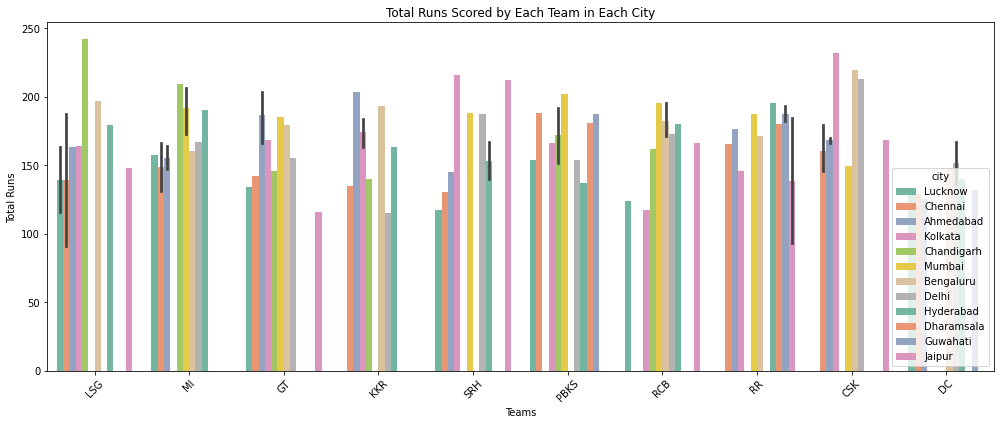

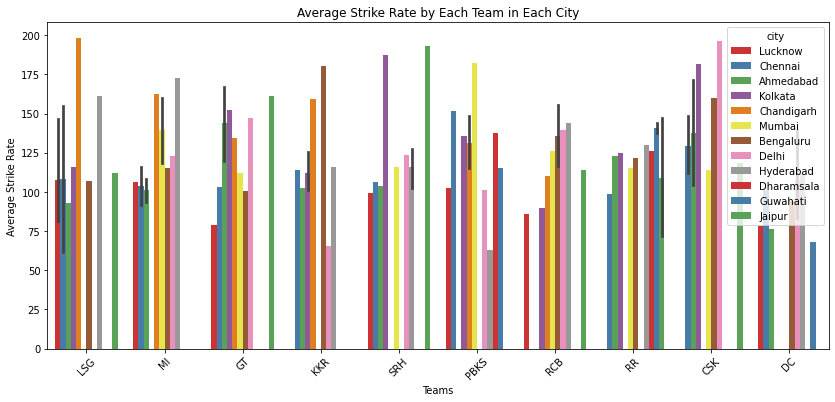

In [ ]:

# Convert to Pandas DataFrame
stats_by_city_pd = stats_by_city_df.toPandas()

# Check for NaN values
print(stats_by_city_pd.isnull().sum())

# Drop or fill NaN values
stats_by_city_pd = stats_by_city_pd.dropna()

# Ensure correct data types
stats_by_city_pd['total_runs'] = pd.to_numeric(stats_by_city_pd['total_runs'], errors='coerce')
stats_by_city_pd['avg_strike_rate'] = pd.to_numeric(stats_by_city_pd['avg_strike_rate'], errors='coerce')

# Create the bar plots again
plt.figure(figsize=(14, 6))
sns.barplot(x='current_innings', y='total_runs', hue='city', data=stats_by_city_pd, palette='Set2')
plt.title('Total Runs Scored by Each Team in Each City')
plt.xlabel('Teams')
plt.ylabel('Total Runs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x='current_innings', y='avg_strike_rate', hue='city', data=stats_by_city_pd, palette='Set1')
plt.title('Average Strike Rate by Each Team in Each City')
plt.xlabel('Teams')
plt.ylabel('Average Strike Rate')
plt.xticks(rotation=45)
plt.show()



In [ ]:
bat_all_szn_df_filtered.show(5)
bowl_all_szn_df_filtered.show(5)

+------+--------+----------+---------+---------+--------------------+---------+---------------+----------+----------+---------------+----+----------+-------+-----+-----+----------+-------+--------+-----------+--------------------+
|season|match_id|match_name|home_team|away_team|               venue|     city|current_innings|innings_id|      name|       fullName|runs|ballsFaced|minutes|fours|sixes|strikeRate|captain|isNotOut|runningOver|           shortText|
+------+--------+----------+---------+---------+--------------------+---------+---------------+----------+----------+---------------+----+----------+-------+-----+-----+----------+-------+--------+-----------+--------------------+
|2023.0| 1359475|  GT v CSK|       GT|      CSK|Narendra Modi Sta...|Ahmedabad|            CSK|       1.0| DP Conway|   Devon Conway| 1.0|       6.0|   null|  0.0|  0.0|     16.66|  false|   false|       2.20|    b Mohammed Shami|
|2023.0| 1359475|  GT v CSK|       GT|      CSK|Narendra Modi Sta...|Ahmedab

In [ ]:
# Get Total Number of runs scored by CSK in 2023 Season GT v CSK match

runs_scored_each_innings = bat_all_szn_df_filtered.groupBy('match_id', 'match_name','innings_id').agg(
    F.sum('runs').alias('innings_runs')
)



In [ ]:
# Show the total runs scored for each match by both the teams
windowSpec = Window.partitionBy('match_id')

runs_scored_total_per_match = runs_scored_each_innings.withColumn(
    'total_runs_per_match', 
    F.sum('innings_runs').over(windowSpec)
)

runs_scored_each_innings_desc = runs_scored_total_per_match.orderBy(F.col('match_id').desc())



In [ ]:
runs_scored_each_innings_desc.show(50)

+--------+----------+----------+------------+--------------------+
|match_id|match_name|innings_id|innings_runs|total_runs_per_match|
+--------+----------+----------+------------+--------------------+
| 1370353|  GT v CSK|       1.0|       210.0|               376.0|
| 1370353|  GT v CSK|       2.0|       166.0|               376.0|
| 1370352|   GT v MI|       2.0|       164.0|               387.0|
| 1370352|   GT v MI|       1.0|       223.0|               387.0|
| 1370351|  LSG v MI|       1.0|       166.0|               257.0|
| 1370351|  LSG v MI|       2.0|        91.0|               257.0|
| 1370350|  CSK v GT|       1.0|       167.0|               309.0|
| 1370350|  CSK v GT|       2.0|       142.0|               309.0|
| 1359544|  RCB v GT|       1.0|       190.0|               369.0|
| 1359544|  RCB v GT|       2.0|       179.0|               369.0|
| 1359543|  MI v SRH|       1.0|       188.0|               383.0|
| 1359543|  MI v SRH|       2.0|       195.0|               38

In [ ]:
# Find the batsman with highest strike rate, and most economical bowler for each innings in each match every year.
# match_id, match_name, venue, city, innings_id, batsman_name, batting_team, batsman_strike_rate, bowlers_name, bowling_team, bowlers_economy_rate


# batting strike rate
bat_selected_cols = all_seasons_batting_card_df.select('season','match_id','match_name','city','fullName','current_innings','strikeRate')
bat_selected_cols.show(10)

# bowling economy rate
bowl_selected_cols = all_seasons_bowling_card_df.select('match_id','fullName','bowling_team','economyRate')
bowl_selected_cols.show(10)



+------+--------+----------+---------+----------------+---------------+----------+
|season|match_id|match_name|     city|        fullName|current_innings|strikeRate|
+------+--------+----------+---------+----------------+---------------+----------+
|2023.0| 1359475|  GT v CSK|Ahmedabad|    Devon Conway|            CSK|     16.66|
|2023.0| 1359475|  GT v CSK|Ahmedabad| Ruturaj Gaikwad|            CSK|     184.0|
|2023.0| 1359475|  GT v CSK|Ahmedabad|       Moeen Ali|            CSK|    135.29|
|2023.0| 1359475|  GT v CSK|Ahmedabad|      Ben Stokes|            CSK|    116.66|
|2023.0| 1359475|  GT v CSK|Ahmedabad|   Ambati Rayudu|            CSK|     100.0|
|2023.0| 1359475|  GT v CSK|Ahmedabad|     Shivam Dube|            CSK|    105.55|
|2023.0| 1359475|  GT v CSK|Ahmedabad| Ravindra Jadeja|            CSK|      50.0|
|2023.0| 1359475|  GT v CSK|Ahmedabad|        MS Dhoni|            CSK|     200.0|
|2023.0| 1359475|  GT v CSK|Ahmedabad|Mitchell Santner|            CSK|     33.33|
|202

In [ ]:
bat_cleaned_df = (
    bat_selected_cols
    .withColumn('season', F.col('season').cast('int'))  # Cast 'season' to integer
    .dropna(subset=['season'])  # Drop rows where 'season' is null
)

bat_ordered_df = (
    bat_cleaned_df
    .orderBy(
        F.col('match_id'),      # Order by match_id in descending order
        F.col('strikeRate').desc(),     # Order by strikeRate in descending order
        F.col('season')
    )
    .dropDuplicates(['match_id'])      # Ensure match_id is unique
)

bat_ordered_df.createOrReplaceTempView('bat_ordered_view')

bat_ordered_df.show(100)



+------+--------+----------+--------------+--------------------+---------------+----------+
|season|match_id|match_name|          city|            fullName|current_innings|strikeRate|
+------+--------+----------+--------------+--------------------+---------------+----------+
|  2008|  335982| RCB v KKR|     Bengaluru|    Brendon McCullum|            KKR|    216.43|
|  2008|  335983|KXIP v CSK|    Chandigarh|        Suresh Raina|            CSK|    246.15|
|  2008|  335984|   DC v RR|         Delhi|     Virender Sehwag|             DC|     300.0|
|  2008|  335985|  MI v RCB|        Mumbai|       Shaun Pollock|             MI|    233.33|
|  2008|  335986|  KKR v DC|       Kolkata|       Sanjay Bangar|            SRH|     140.0|
|  2008|  335987| RR v KXIP|        Jaipur|    Kumar Sangakkara|           KXIP|     250.0|
|  2008|  335988|  SRH v DC|     Hyderabad|     Virender Sehwag|             DC|    229.26|
|  2008|  335989|  CSK v MI|       Chennai|          Jacob Oram|            CSK|

In [ ]:
# Ordering for Bowling Card

bowl_ordered_df = (
    bowl_selected_cols.orderBy(
        F.col('match_id'),
        F.col('economyRate'),
    )
    .dropDuplicates(['match_id'])
)

bowl_ordered_df.show()

bowl_ordered_df.createOrReplaceTempView('bowl_ordered_view')


+--------+--------------------+------------+-----------+
|match_id|            fullName|bowling_team|economyRate|
+--------+--------------------+------------+-----------+
|  335982|       Ishant Sharma|         KKR|       2.33|
|  335983|Muttiah Muralitharan|         CSK|       8.25|
|  335984|    Farveez Maharoof|          DC|       2.75|
|  335985|         Zaheer Khan|         RCB|       4.25|
|  335986|     Mohammad Hafeez|         KKR|       2.00|
|  335987|         Shane Warne|          RR|       4.75|
|  335988|       Mohammad Asif|          DC|       4.75|
|  335989|       Manpreet Gony|         CSK|       4.50|
|  335990|        Pankaj Singh|          RR|       7.00|
|  335991|           Brett Lee|        KXIP|       2.25|
|  335992|        Shane Watson|          RR|       5.00|
|  335993|Muttiah Muralitharan|         CSK|       3.00|
|  335994|            RP Singh|         SRH|       3.75|
|  335995|        Rajat Bhatia|          DC|       5.00|
|  335996|          Jacob Oram|

In [ ]:
# join both tables based on match_id
strikeRate_economyRate_summary = spark.sql("""
    SELECT * 
    FROM bat_ordered_view batCard
    JOIN bowl_ordered_view bowlCard ON bowlCard.match_id = batCard.match_id
""")

# rename columns using Method chaining
strikeRate_economyRate_summary_df = (
    strikeRate_economyRate_summary
    .withColumnRenamed('batCard.season', 'year')  
    .withColumnRenamed('batCard.match_name', 'match')  
    .withColumnRenamed('batCard.fullName', 'batter')  
    .withColumnRenamed('batCard.current_innings', 'batting_team') 
    .withColumnRenamed('batCard.strikeRate', 'strike_rate')  
    .withColumnRenamed('bowlCard.fullName', 'bowler') 
    .withColumnRenamed('bowlCard.bowling_team', 'bowling team') 
    .withColumnRenamed('bowlCard.economyRate', 'economy rate') 
    .drop('match_id')  
)


strikeRate_economyRate_summary_df.show()



# Find the batsman with highest strike rate, and most economical bowler for each innings in each match in every year.
# match_id, match_name, venue, city, innings_id, batsman_name, batting_team, batsman_strike_rate, bowlers_name, bowling_team, bowlers_economy_rate

# View result below

+------+----------+----------+------------------+---------------+----------+--------------------+------------+-----------+
|season|match_name|      city|          fullName|current_innings|strikeRate|            fullName|bowling_team|economyRate|
+------+----------+----------+------------------+---------------+----------+--------------------+------------+-----------+
|  2008| RCB v KKR| Bengaluru|  Brendon McCullum|            KKR|    216.43|       Ishant Sharma|         KKR|       2.33|
|  2008|KXIP v CSK|Chandigarh|      Suresh Raina|            CSK|    246.15|Muttiah Muralitharan|         CSK|       8.25|
|  2008|   DC v RR|     Delhi|   Virender Sehwag|             DC|     300.0|    Farveez Maharoof|          DC|       2.75|
|  2008|  MI v RCB|    Mumbai|     Shaun Pollock|             MI|    233.33|         Zaheer Khan|         RCB|       4.25|
|  2008|  KKR v DC|   Kolkata|     Sanjay Bangar|            SRH|     140.0|     Mohammad Hafeez|         KKR|       2.00|
|  2008| RR v KX

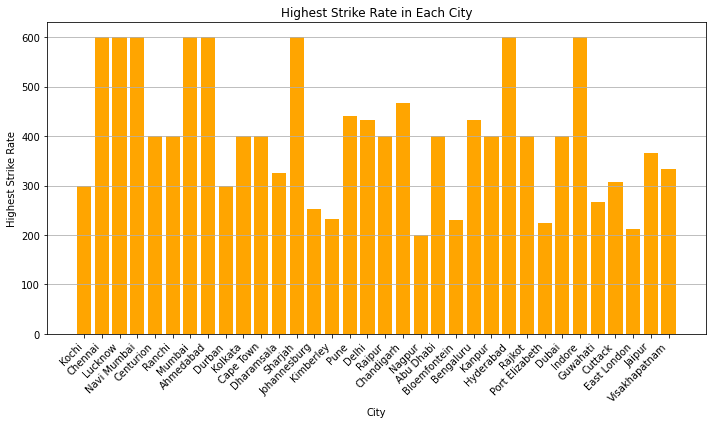

In [ ]:

# Group by city and find the maximum strike rate for each city
highest_strike_rate_city_df = (
    strikeRate_economyRate_summary_df
    .groupBy('city')  
    .agg(F.max('strikeRate').alias('max_strike_rate'))  # Get maximum strike rate per city
)

# Convert the result to a Pandas DataFrame for plotting
highest_strike_rate_city_pd = highest_strike_rate_city_df.toPandas()


# Plotting the highest strike rate per city
plt.figure(figsize=(10, 6))
plt.bar(highest_strike_rate_city_pd['city'], highest_strike_rate_city_pd['max_strike_rate'], color='orange')

# Add labels and title
plt.xlabel('City')
plt.ylabel('Highest Strike Rate')
plt.title('Highest Strike Rate in Each City')
plt.xticks(rotation=45, ha='right')  # Rotate the city names for better readability
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()




<command-651577914288081>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(city_player_stats_pd['city'], rotation=45, ha='right')


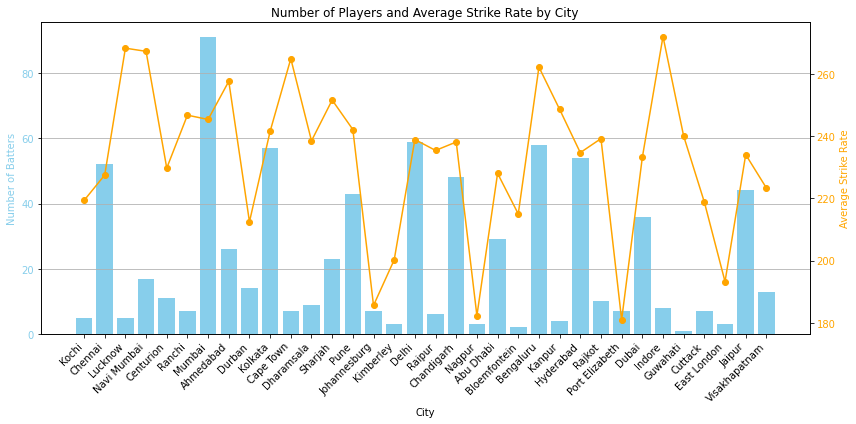

In [ ]:


# Group by city to calculate the number of unique players and the average strike rate
city_player_stats_df = (
    bat_ordered_df
    .groupBy('city')
    .agg(
        F.countDistinct('fullName').alias('num_batters'),  # Count of distinct batters per city
        F.avg('strikeRate').alias('avg_strike_rate')  # Average strike rate per city
    )
)

# Cast avg_strike_rate to DoubleType to avoid the DecimalType conversion warning
city_player_stats_df = city_player_stats_df.withColumn('avg_strike_rate', F.col('avg_strike_rate').cast(DoubleType()))

# Convert the result to a Pandas DataFrame for plotting
city_player_stats_pd = city_player_stats_df.toPandas()

# Plotting the number of players and their average strike rate for each city
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot number of players
ax1.bar(city_player_stats_pd['city'], city_player_stats_pd['num_batters'], color='skyblue', label='Number of Batters')
ax1.set_xlabel('City')
ax1.set_ylabel('Number of Batters', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(city_player_stats_pd['city'], rotation=45, ha='right')

# Create a secondary axis for average strike rate
ax2 = ax1.twinx()
ax2.plot(city_player_stats_pd['city'], city_player_stats_pd['avg_strike_rate'], color='orange', marker='o', label='Average Strike Rate')
ax2.set_ylabel('Average Strike Rate', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and grid
plt.title('Number of Players and Average Strike Rate by City')
ax1.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

